# Unsupervised Shallow Machine Learning Models: XGBoost Regression

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; padding: 10px; margin: 10px 0; text-align: center;">
    
    XGBoost: gradient boosting ensemble method that builds decision trees sequentially, with each new tree correcting errors from previous ones to optimise a differentiable loss function and capture complex nonlinear relationships.
<div>

### Import Libraries including `sklearn`, `xgboost`, and `shap`

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap

# Data Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Load CSV files containing variables -- `glob` and pandas' `read_csv function`

In [2]:
# Define the file pattern to match relevant CSV files
file_pattern = "cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_*.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    var_name = file.split("_")[-1].split(".")[0]  # Extract variable name from filename
    df_dict[var_name] = pd.read_csv(file, comment='#')

# Ensure SSH is processed correctly (dates + renaming 'zos' to 'SSH')
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['dates'] = SSH['dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['dates'] = pd.to_datetime(SSH['dates'])
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})  # Rename 'zos' to 'SSH'
    SSH = SSH[['dates', 'SSH']]  # Keep 'dates' and SSH variable

# Mapping of expected variables to their corresponding column names in CSVs
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Merge all datasets dynamically
df = SSH.copy() if SSH is not None else pd.DataFrame()

for key, col in data_vars.items():
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key  # Ensure velocity data is accessed correctly
    if dataset_key in df_dict:
        df[key] = df_dict[dataset_key][col].values  # Assign values from each dataset

# Print the first few rows to verify the result
print(df.head())

       dates       SSH        SST        SSS       Vuo       Vvo        MLD
0 1993-01-01 -0.096133  25.840723  36.259041 -0.104373  0.850246  66.225166
1 1993-01-02 -0.106815  25.672995  36.251411 -0.169683  0.775780  69.124428
2 1993-01-03 -0.137028  25.314096  36.233101 -0.120243  0.763573  63.325909
3 1993-01-04 -0.170598  25.159552  36.242256  0.032960  0.979034  50.813320
4 1993-01-05 -0.165105  25.166143  36.240730  0.083010  1.031526  49.897766


### Set the `predictor` and `target` variables (X, y)

In [3]:
predictors = ['SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X = df[predictors].values 
y = df['SST'].values      # Target variable
# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(10408, 5) (10408,)


### Split the data into two sets: `training` (80%) and `test` (20%)

In [4]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:",  X_test.shape[0])

Trainin set size: 8326
Testing set size: 2082


<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    XGBoost Regressor
<div>

In [5]:
# Initialise the XGBoost regressor with the squared error objective.
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42)

In [6]:
#Fit the model on the training set
xgb_reg.fit(X_train, y_train)

# Predict SST on the test dataset
y_pred = xgb_reg.predict(X_test)

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Visualising Model Performance: simple `line plot`

In [7]:
# Compute the difference
diff = (y_pred - y_test)

# Create a DataFrame for comparison
xgb_df = pd.DataFrame({
    'Modeled': y_pred,
    'Actual': y_test,
    'SST_diff': diff})

# Reset index
xgb_df.reset_index(drop=True, inplace=True)
# Show df
print(xgb_df.head(4))

     Modeled     Actual  SST_diff
0  28.166842  28.435041 -0.268200
1  28.262041  29.601826 -1.339785
2  25.448395  25.901516 -0.453121
3  27.554596  29.600361 -2.045765


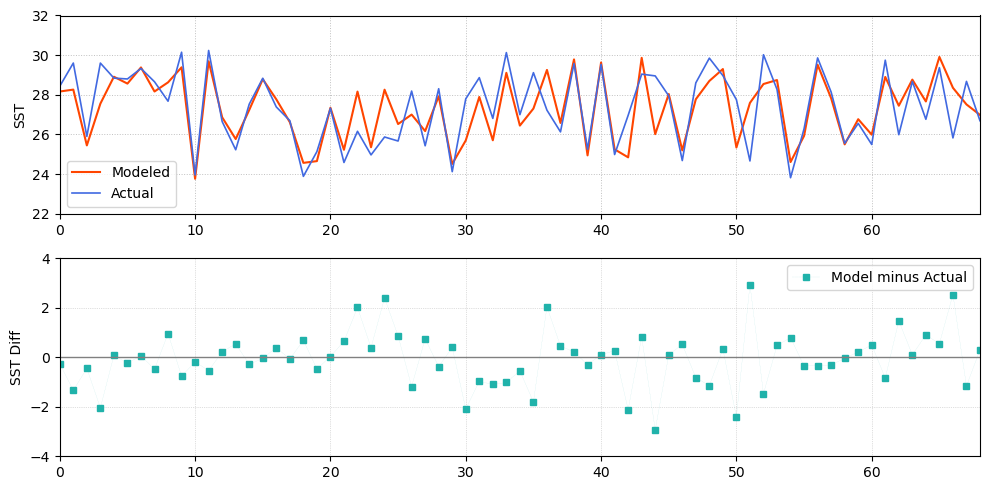

In [8]:
# Plot findings using two subplots (2 rows, 1 column)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# Plot Actual and Modeled SST values
ax[0].plot(xgb_df.index, xgb_df['Modeled'],linestyle='-', c='orangered', linewidth=1.5, label='Modeled')
ax[0].plot(xgb_df.index, xgb_df['Actual'], linestyle='-', c='royalblue', linewidth=1.2, label='Actual')
# Set the x and y axes
ax[0].set_xlim(0, 68)  
ax[0].set_ylim(22,32)
# Format your line plot
ax[0].grid(True, color='silver', linestyle=':', linewidth=0.7)
ax[0].set_ylabel('SST')
ax[0].legend()

# Plot SST_diff values
ax[1].plot(xgb_df.index, xgb_df['SST_diff'], linestyle=':', linewidth = 0.1, marker = 's', markersize = 5, 
           color = 'lightseagreen', label = 'Model minus Actual')
# Set the x and y axes
ax[1].set_xlim(0, 68)  
ax[1].set_ylim(-4, 4)
# Add thick line at 0 to highlight differences in SST
ax[1].axhline(y = 0, color = 'grey', linewidth = 1.0)
# Format your line plot
ax[1].grid(True, color='silver', linestyle=':', linewidth = 0.5)
ax[1].set_ylabel('SST Diff')
ax[1].legend()

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()

### Metrics for XGBoost Model: `R2` and `RMSE`

In [9]:
# Evaluate xgb Model Performance - RMSE, R² score
rmse= np.sqrt(mean_squared_error(y_test, y_pred))
r2  = r2_score(y_test, y_pred)

# Print output to 2 decimal places:
print(f"XGBoost R²  : {r2:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")

XGBoost R²  : 0.70
XGBoost RMSE: 1.09


### That's not the improvement we were hoping for... 

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Hyperparameter Tuning Using GridSearchCV
</div>

In [16]:
# Define a parameter grid (dictionary) with lists of possible values for each hyperparameter:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 5, 7],                        # Maximum depth of a tree, controlling model complexity
    'min_child_weight': [1, 3, 5],                 # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.7, 0.8, 0.9, 1.0],             # Fraction of samples to use for each tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],      # Fraction of features to consider for each tree
    'n_estimators': [100, 200, 300],               # Number of trees (boosting rounds) to build
    'gamma': [0, 0.1, 0.5]                         # Minimum loss reduction required to make a split
}

# Initialise XGBoost regressor model with squared error objective.
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42)

# Set up RandomizedSearchCV with the following parameters:
random_search = RandomizedSearchCV(
    estimator = xgb_reg,                          # The base model to optimize (our XGBoost regressor)
    param_distributions=param_grid,               # Dictionary with parameters to sample from (our grid)
    n_iter = 100,                                 # Number of random parameter combinations to try (reduces total fits)
    scoring='r2',                                 # Metric to evaluate performance (R² in this case)
    cv = 5,                                       # Number of cross-validation folds (5-fold cross-validation)
    verbose= 1,                                   # Verbosity level to print progress messages during the search
    n_jobs =-1,                                   # Use all available CPU cores to parallelize the search
    random_state = 42                             # Random seed for reproducibility of the random sampling
)

# Fit the randomised search on the training data:
random_search.fit(X_train, y_train)

# Print best hyperparameters and cross-validation (CV) scores
print("Best parameters:", random_search.best_params_)
print()
print("Best XGBoost CV R²: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}

Best XGBoost CV R²: 0.72


### That's better - we see a (modest) improvement from `R²`= 0.70 to `R²`= 0.72. We can now save this 'best' model using a built-in function `save_model()`.

In [11]:
# Save the model to a JSON file
random_search.best_estimator_.save_model("xgb_sst_model1.json")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Feature Importance
</div>

In [12]:
# Using SHAP to explain our model predictions with XGBoost
explainer = shap.TreeExplainer(random_search.best_estimator_)  # Use best_estimator_ from random_search
shap_vals = explainer.shap_values(X_test)                      # Compute SHAP values for your test data

# Get feature importance from the XGBoost model
boost_importance = pd.Series(random_search.best_estimator_.feature_importances_,
                             index = predictors) # predictors= variables (SSH, MLD, SSS)

# Create df of the features and their importance (xgboost)
boost_df = pd.DataFrame({
    "Variable": predictors,
    "XGB Importance": boost_importance})

# Sort boost_df so most important variables are at the top (descending order)
boost_df.sort_values(by = "XGB Importance", ascending = False, inplace = True)
print(boost_df)

    Variable  XGB Importance
MLD      MLD        0.439964
SSH      SSH        0.394417
SSS      SSS        0.102820
Vvo      Vvo        0.038340
Vuo      Vuo        0.024459


In [13]:
# Compute the mean absolute SHAP values for each feature
# This provides a robust measure of feature importance
shap_importance = np.abs(shap_vals).mean(axis = 0)

# Create df of the features and their importance (SHAP)
shap_df = pd.DataFrame({
    "Variable": predictors,
    "Mean Absolute SHAP": shap_importance})

# Sort shap_df so the most important features (variables) are at the top:
shap_df.sort_values(by = "Mean Absolute SHAP", ascending = False, inplace = True)
print(shap_df)

  Variable  Mean Absolute SHAP
4      MLD            0.930823
0      SSH            0.928598
1      SSS            0.331900
3      Vvo            0.117594
2      Vuo            0.070762


In [14]:
# For plotting SHAP:
# Use the diverging "Spectral" palette for colormap:
cmap = sns.color_palette("Spectral", as_cmap = True)

# Compute normalized ranking for each feature (btwn 0 - 1)
# Note -- shap_df values used to determine relative order:
norm_ranks = shap_df["Mean Absolute SHAP"].rank(pct = True)

# Map each normalized rank to a colour via colourmap:
colors = norm_ranks.apply(lambda x: cmap(x)).tolist()

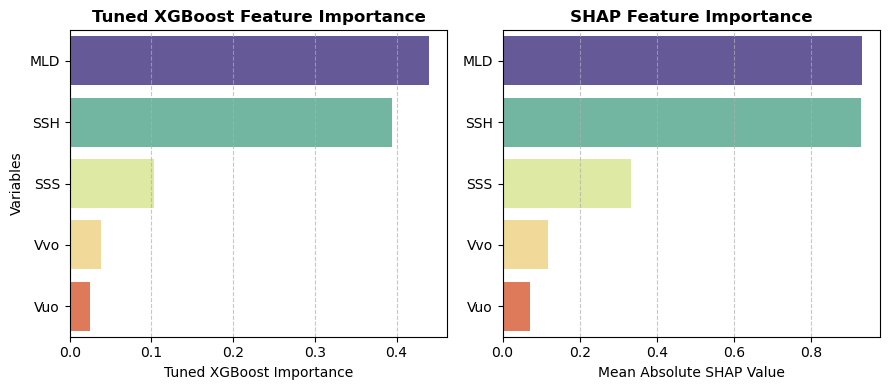

In [15]:
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# ----- Plot RF Feature Importance -----
sns.barplot(data = boost_df, x = "XGB Importance", y = "Variable", ax = axes[0],
    palette = colors)
axes[0].set_title("Tuned XGBoost Feature Importance", fontweight='bold')
axes[0].set_xlabel("Tuned XGBoost Importance", fontsize = 10)
axes[0].set_ylabel("Variables", fontsize = 10)
axes[0].grid(axis = 'x', linestyle = '--', alpha = 0.7)

# ----- Plot SHAP Feature Importance -----
sns.barplot(data = shap_df, x = "Mean Absolute SHAP", y ="Variable", ax=axes[1],
    palette = colors)
axes[1].set_title("SHAP Feature Importance", fontweight ='bold')
axes[1].set_xlabel("Mean Absolute SHAP Value", fontsize = 10)
axes[1].set_ylabel("")  # Remove redundant ylabel on the right plot
axes[1].grid(axis = 'x', linestyle = '--', alpha = 0.7)

# Show plots
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.em; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">

    While the feature importance ranking is similar (MLD and SSH at the top), their scales and interpretations differ:
    
    ⦾ XGBoost Feature Importance 
       - Calculated based on the reduction in impurity (or gain) that each feature provides when used for splits.
       - Normalized (0 - 1), so they represent the relative importance of features in splitting decisions.
       - Rankings are more about the model's inner workings:
       - i.e.: how frequently and effectively features are used to split nodes and reduce error during model training.
        
    ⦾ SHAP Mean Absolute Values
       - Computed per sample as the contribution each feature makes to the model’s prediction, then averaged across all samples.
       - Values are in the same units as the output variable (SST), and are not normalised in the same way as XGBoost.
       - More about the actual impact of feature values:
       - i.e.: how much each feature’s actual value contributed to the prediction (game theory foundation).
<div>